In [4]:
import os
import pandas as pd
import numpy as np
import rasterio
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def load_data(paths):
    # Get a list of all files in the directory (X_train, y_train, X_test)
    file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

    # Sort the file list to ensure consistent order
    file_list = [sorted(files) for files in file_list]

    # Initialize an empty array to store the image data
    X_train, y_train, X_test = [], [], []

    # Iterate through the selected files
    for X_train_name, y_train_name in tqdm(zip(file_list[0], file_list[1])):
        # Construct the full path to the file
        X_train_path = os.path.join(paths[0], X_train_name)
        y_train_path = os.path.join(paths[1], y_train_name)

        # Open the raster file using rasterio
        with rasterio.open(X_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            X_train.append(image_data)

        # Open the raster file using rasterio
        with rasterio.open(y_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            y_train.append(image_data)

    # Convert the list of arrays to a single NumPy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

In [6]:
directory_paths = ['../data/raw/train_satellite', '../data/raw/train_kelp']
os.path.abspath(directory_paths[0])
X_train, y_train = load_data(directory_paths)

print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)

0it [00:00, ?it/s]

Shape of the X_train array: (5635, 7, 350, 350)
Shape of the y_train array: (5635, 1, 350, 350)


In [7]:
import scipy


def reshape(img: np.ndarray):
    img = img.transpose(1,2,0)
    img = img.reshape(-1,img.shape[2])
    return img

def to_df(img: np.ndarray, label: np.ndarray):
    
    # Create a dataframe with the base features
    df = pd.DataFrame(reshape(img), columns=['SWIR','NIR', 'R', 'G', 'B','Cloud','Elevation'])
    df['Water'] = df['Elevation'] < 1
    
    df['NDWI'] = (df['G'] - df['NIR']) / (df['G'] + df['NIR'])
    df['MNDWI'] = (df['G'] - df['SWIR']) / (df['G'] + df['SWIR'])
    df['NDVI'] = (df['NIR'] - df['R']) / (df['NIR'] + df['R'])
    
    # Land closeness, roughly inverse distance to land
    land_dist = scipy.ndimage.distance_transform_edt(img[6, :, :] <= 0)
    land_closeness = 1 / (1 + land_dist * 0.1)
    df['LandCloseness'] = land_closeness.flatten()
    
    # Offset features, using difference with median of all water pixels
    if df['Water'].sum() > 0:
        df['ONIR'] = df['NIR'] - df[df['Water']]['NIR'].median() 
        
        ROffset = df['R'] - df[df['Water']]['R'].median()
        GOffset = df['G'] - df[df['Water']]['G'].median()
        df['ODWI'] = (GOffset - df['ONIR'])
        df['ODVI'] = (df['ONIR'] - ROffset)
    else:
        df['ONIR'] = 0
        df['ODWI'] = 0
        df['ODVI'] = 0
        
    
    # Add the label to the dataframe
    df['Label'] = label.flatten()
    return df

In [8]:
# Get the last N images for testing (trained on the first 3000)
N = 1000
X_test = pd.concat([to_df(X_train[-i], y_train[-i]) for i in tqdm(range(1, N+1))])
X_training = pd.concat([to_df(X_train[i], y_train[i]) for i in tqdm(range(2000))])


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [98]:
X_training = pd.concat([to_df(X_train[i], y_train[i]) for i in tqdm(range(1000))])
Y_training = y_train[:1000].ravel()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [78]:
#1000 to 2000
X_val = pd.concat([to_df(X_train[i], y_train[i]) for i in tqdm(range(1000,2000))])
Y_val = y_train[1000:2000].ravel()

  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
# load the catboost_model.cbm
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.load_model('./catboost_model.cbm')

# load the catboost_features.txt
with open('./catboost_features.txt') as f:
    features = f.read().splitlines()

In [71]:
# Train a random forest
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, n_jobs=-1, early_stopping_rounds=10)
model.fit(X_training[features], Y_training, eval_set = [(X_val[features], Y_val)])   

[0]	validation_0-logloss:0.10097
[1]	validation_0-logloss:0.07608
[2]	validation_0-logloss:0.05862
[3]	validation_0-logloss:0.04561
[4]	validation_0-logloss:0.03627
[5]	validation_0-logloss:0.02936
[6]	validation_0-logloss:0.02434
[7]	validation_0-logloss:0.02009
[8]	validation_0-logloss:0.01715
[9]	validation_0-logloss:0.01500
[10]	validation_0-logloss:0.01364
[11]	validation_0-logloss:0.01227
[12]	validation_0-logloss:0.01144
[13]	validation_0-logloss:0.01069
[14]	validation_0-logloss:0.01025
[15]	validation_0-logloss:0.00936
[16]	validation_0-logloss:0.00906
[17]	validation_0-logloss:0.00883
[18]	validation_0-logloss:0.00866
[19]	validation_0-logloss:0.00830
[20]	validation_0-logloss:0.00798
[21]	validation_0-logloss:0.00750
[22]	validation_0-logloss:0.00746
[23]	validation_0-logloss:0.00742
[24]	validation_0-logloss:0.00733
[25]	validation_0-logloss:0.00728
[26]	validation_0-logloss:0.00717
[27]	validation_0-logloss:0.00702
[28]	validation_0-logloss:0.00699
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [101]:
# Train lightGBM
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, early_stopping_rounds=10, verbose=1, num_iterations=50)
model.fit(X_training[features], Y_training, eval_set = [(X_val[features], Y_val)])

C:\Users\hjdeh\Documents\GitHub\Q2\q2-detect-kelp\venv\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Number of positive: 895112, number of negative: 121604888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 122500000, number of used features: 12
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007307 -> initscore=-4.911584
[LightGBM] [Info] Start training from score -4.911584
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.0180829


LGBMClassifier(early_stopping_rounds=10, n_jobs=-1, num_iterations=50,
               verbose=1)

In [102]:
# Make predictions on the test data
y_pred = model.predict_proba(X_test[features])[:, 1]

In [103]:
def blur_preds(pred: np.ndarray, sigma: float = 3):
    """Given the flat predictions one or more images, blur the predictions in 2D and flatten again"""
    img = pred.reshape(-1, 350, 350)
    img = scipy.ndimage.gaussian_filter(img, sigma=sigma)
    return img.flatten()

def get_dice(pred: np.ndarray, label: np.ndarray, thresh: float = 0.5):
    """Given the flat predictions of single image, calculate the dice score"""
    pred = pred > thresh
    return 2 * np.sum(pred * label) / (np.sum(pred) + np.sum(label))

In [104]:
# Perform a grid search over blur sigma and threshold
results = []
sigmas = np.arange(0, 3, 0.5)
threshs = np.arange(0, 0.8, 0.01)
pbar = tqdm(total=len(sigmas) * len(threshs))
for sigma in sigmas:
    y_pred_blur = blur_preds(y_pred, sigma=sigma)
    for thresh in threshs:
        dice = get_dice(y_pred_blur, X_test['Label'], thresh=thresh)
        results.append([sigma, thresh, dice])
        pbar.update(1)

  0%|          | 0/480 [00:00<?, ?it/s]

In [91]:
# record the results in a dataframe
df = pd.DataFrame(results, columns=['sigma', 'thresh', 'dice'])

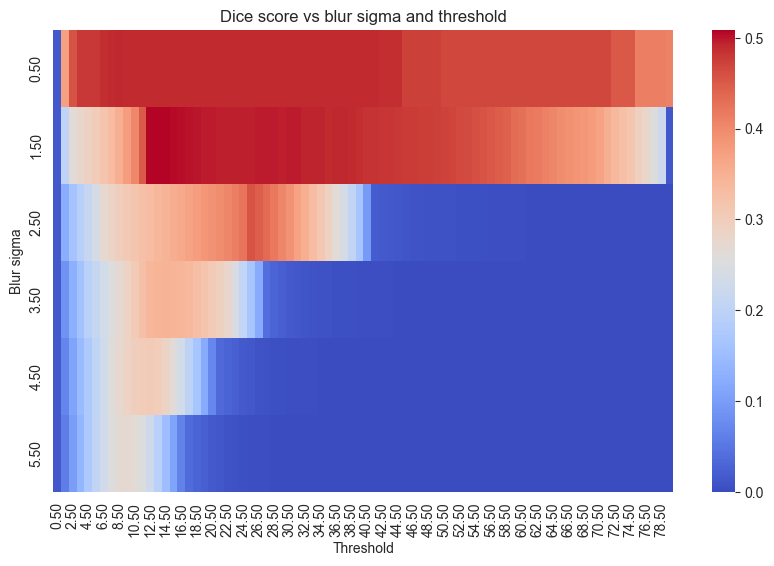

In [105]:
# Plot the results in a heatmap
plt.figure(figsize=(10, 6))
arr = df.pivot(index='sigma', columns='thresh', values='dice')
sns.heatmap(arr, cmap='coolwarm')
plt.title('Dice score vs blur sigma and threshold')
plt.xlabel('Threshold')
plt.ylabel('Blur sigma')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
plt.show()

In [106]:
# print the default score from the dataframe (no blur)
print("Default score:")
default = df[(df['sigma'] == 0) & (df['thresh'] == 0.5)]
print(f'No blur, thresh 0.50: {default["dice"].values[0]:.4f}')

print("\nOptimising thresh:")
no_blur = df[df['sigma'] == 0]
best_thresh_no_blur = no_blur.sort_values('dice', ascending=False).iloc[0, 1]
print(f'No blur, thresh {best_thresh_no_blur}: {no_blur["dice"].max():.4f}')


# Get the best sigma and threshold
best_sigma, best_thresh = df.sort_values('dice', ascending=False).iloc[0, :2]
print("\nOptimising both:")
print(f'Best sigma: {best_sigma:.2f}')
print(f'Best threshold: {best_thresh:.2f}')
print(f'Best dice score: {df["dice"].max():.4f}')

Default score:
No blur, thresh 0.50: 0.4684

Optimising thresh:
No blur, thresh 0.08: 0.4923

Optimising both:
Best sigma: 0.50
Best threshold: 0.12
Best dice score: 0.5085


In [61]:
# Save the model to a file 
import pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model from a file
with open('xgboost_model.pkl', 'rb') as f:
    model = pickle.load(f)